# Investigating adjusted p-values from 0ppm vs 1500ppm eQTL analysis

__Author:__ Bryan Quach  
__Date:__ May 2, 2017

### Estimated Analysis Time: <1 days

## Objective

There are multiple objectives of this analysis. The main goal is to apply multiple testing correction to the initial results of the eQTL analyses (unadjusted p-values). Following the multiple testing correction, we will address the following questions:

* What is the q-value distribution of our results?
* How many gene-marker pairs produced a significant association?
* How many statistically significant eQTL-containing genes (eGenes) are observed?
* Which gene and marker comparisons produced the most significant hits?
* Which genes tested are eGenes?

## Software required

* [dplyr (R package)](https://cran.r-project.org/web/packages/dplyr/index.html)
* [qvalue (R package)](https://www.bioconductor.org/packages/release/bioc/html/qvalue.html)
* [GenomicRanges (R package)](https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html)

## The Data

The data that we work with are results output from running a modified version of Daniel Oreper's eQTL analysis software. This software produces an R data file containing the environment in which the analysis was run, which includes a matrix of p-values with rows and columns corresponding to genes and markers respectively. In this analysis, we will look at results for the eQTL analyses in lung, liver, and kidney. The phenotype was the fold change of normalized expression (TPM) between 1500ppm and 0ppm BD treated CC mice.

## Global multiple testing correction

We apply [FDR correction](https://en.wikipedia.org/wiki/False_discovery_rate) to the p-values from all association tests. The resulting q-values will be used for assessing significance of all gene-marker pairs at a specified threshold. To aid in data analysis, we will convert our matrices of p-values into a data frame with `NA` values removed.

In [1]:
library(dplyr)
library(qvalue)
library(GenomicRanges)

# Function for retrieving non-NA values from matrix
#
# Args:
#   haystack - matrix to search through
#
# Returns a dataframe of the p-values with gene and marker names listed
reshape.results <- function(haystack){
    hits <- which(!is.na(haystack), arr.ind=T)
    rnames <- rownames(haystack)[hits[,1]]
    cnames <- colnames(haystack)[hits[,2]]    
    pvals <- sapply(1:nrow(hits), function(i){haystack[hits[i,1], hits[i,2]]})
    results <- data.frame(gene=rnames, marker=cnames, pval=as.numeric(pvals))
    results <- results[order(results$gene),]
    return(results)
}

#Get p-value matrices for each tissue
tmp.env <- new.env()
load("data/0ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
matrix.lung <- get("out.mat", tmp.env)
load("data/0ppm_vs_1500ppm_liver.Rdata", envir=tmp.env)
matrix.liver <- get("out.mat", tmp.env)
load("data/0ppm_vs_1500ppm_kidney.Rdata", envir=tmp.env)
matrix.kidney <- get("out.mat", tmp.env)
rm(tmp.env)

#Reshape
pvals.lung <- reshape.results(matrix.lung)
pvals.liver <- reshape.results(matrix.liver)
pvals.kidney <- reshape.results(matrix.kidney)

#Apply FDR correction
qvals.lung <- qvalue(pvals.lung$pval, fdr.level=0.1) 
qvals.liver <- qvalue(pvals.liver$pval, fdr.level=0.1)
qvals.kidney <- qvalue(pvals.kidney$pval, fdr.level=0.1)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, len

## Identifying significant eGenes

For downstream analyses that focus only on the gene-level results, we will assign a representative p-value for each gene. A common approach to do this is to use the smallest p-value for a gene across tests as a test statistic. A permutation test is then applied where the gene expression values are permuted, and a p-value is derived from this permutation test procedure. Because this is computationally too expensive given our current resources, we will instead apply [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to the p-values from each marker test with a gene. In this approach we tabulate the number of tests performed for each gene then multiply each p-value by that number. We will use the smallest Bonferroni corrected p-value as the representative p-value for a gene. We will then account for multiple comparisons across genes by appyling FDR correction.

In [2]:
#Apply Bonferroni correction
matrix.adj.lung <- matrix.lung * apply(matrix.lung,1,function(x){length(which(!is.na(x)))})
matrix.adj.liver <- matrix.liver * apply(matrix.liver,1,function(x){length(which(!is.na(x)))})
matrix.adj.kidney <- matrix.kidney * apply(matrix.kidney,1,function(x){length(which(!is.na(x)))})

#Apply value ceiling of 1 to p-values
matrix.adj.lung <- apply(matrix.adj.lung, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.liver <- apply(matrix.adj.liver, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.kidney <- apply(matrix.adj.kidney, 2, function(x){ifelse(x>1,1,x)})

#Assign representative p-value to each gene
gene.pval.lung <- apply(matrix.adj.lung, 1, min, na.rm=T)
if(length(which(gene.pval.lung==Inf))>0){ gene.pval.lung <- gene.pval.lung[-1*which(gene.pval.lung==Inf)] }
gene.pval.liver <- apply(matrix.adj.liver, 1, min, na.rm=T)
if(length(which(gene.pval.liver==Inf))>0){ gene.pval.liver <- gene.pval.liver[-1*which(gene.pval.liver==Inf)] }
gene.pval.kidney <- apply(matrix.adj.kidney, 1, min, na.rm=T)
if(length(which(gene.pval.kidney==Inf))>0){ gene.pval.kidney <- gene.pval.kidney[-1*which(gene.pval.kidney==Inf)] }

#Apply FDR correction
gene.qval.lung <- qvalue(p=gene.pval.lung, fdr.level=0.1)
gene.qval.liver <- qvalue(p=gene.pval.liver, fdr.level=0.1)
gene.qval.kidney <- qvalue(p=gene.pval.kidney, fdr.level=0.1)

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”

## Plotting statistics

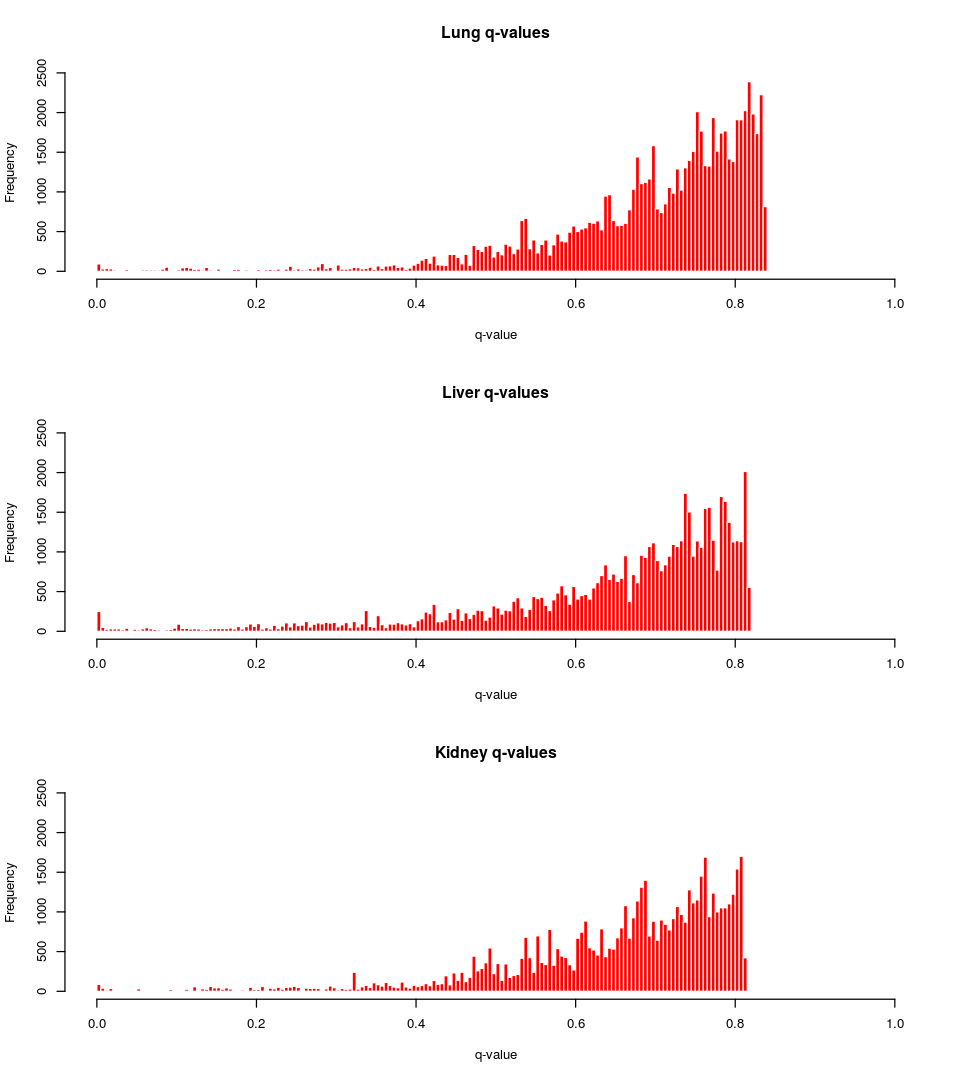

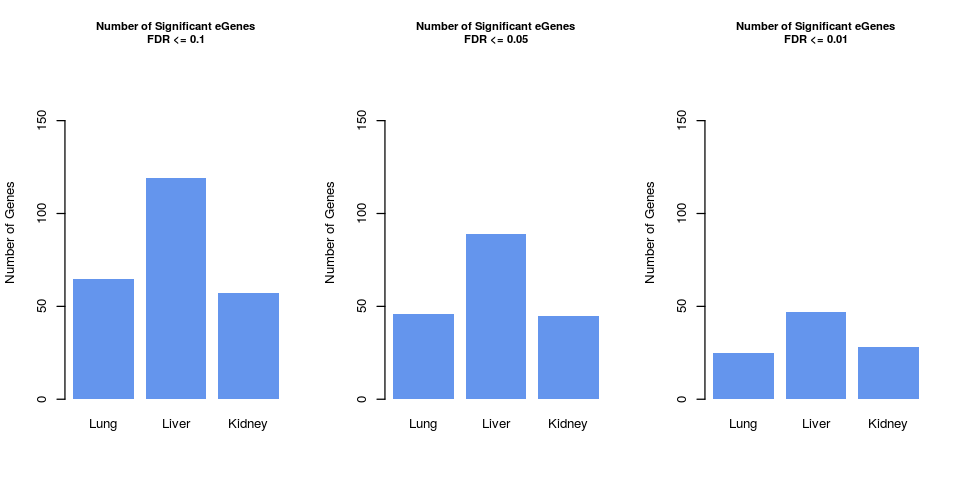

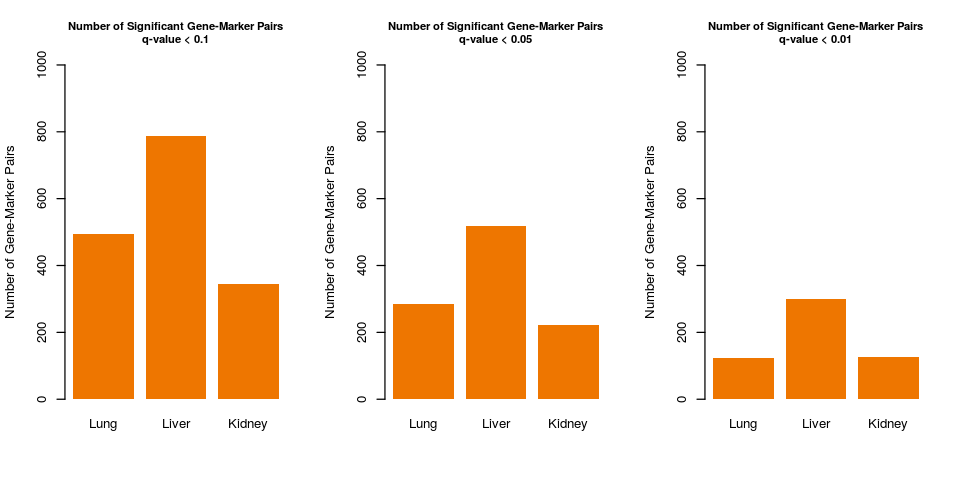

In [3]:
library(repr)

#P-value distributions
options(repr.plot.width=8, repr.plot.height=9)
par(mfrow=c(3,1))
hist(as.numeric(qvals.lung$qvalues), breaks=200, freq=T, ylim=c(0,2500), xlim=c(0,1),
     col="red", border="white",
     main="Lung q-values",
     ylab="Frequency",
     xlab="q-value")
hist(as.numeric(qvals.liver$qvalues), breaks=200, freq=T, ylim=c(0,2500), xlim=c(0,1),
     col="red", border="white",
     main="Liver q-values",
     ylab="Frequency", 
     xlab="q-value")
hist(as.numeric(qvals.kidney$qvalues), breaks=200, freq=T, ylim=c(0,2500), xlim=c(0,1),
     col="red", border="white",
     main="Kidney q-values",
     ylab="Frequency", 
     xlab="q-value")


#Calculate significant eGenes and gene marker pairs
for(cutoff in c(0.1,0.05,0.01)){
    num.egenes.lung <- length(which(gene.qval.lung$qvalues<cutoff))
    num.egenes.liver <- length(which(gene.qval.liver$qvalues<cutoff))
    num.egenes.kidney <- length(which(gene.qval.kidney$qvalues<cutoff))
    assign(x=paste0("num.egenes.",cutoff),value=c(num.egenes.lung, num.egenes.liver, num.egenes.kidney))

    num.sig.lung <- length(which(qvals.lung$qvalues<cutoff))
    num.sig.liver <- length(which(qvals.liver$qvalues<cutoff))
    num.sig.kidney <- length(which(qvals.kidney$qvalues<cutoff))
    assign(x=paste0("num.sig.",cutoff),value=c(num.sig.lung, num.sig.liver, num.sig.kidney))
}

#Significant eGenes
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,3))
barplot(height=num.egenes.0.1, beside=T, ylab="Number of Genes", ylim=c(0,180),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.1",
        cex.main=0.85)
barplot(height=num.egenes.0.05, beside=T, ylab="Number of Genes", ylim=c(0,180),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.05",
        cex.main=0.85)
barplot(height=num.egenes.0.01, beside=T, ylab="Number of Genes", ylim=c(0,180),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.01",
        cex.main=0.85)


#Significant gene marker paris
par(mfrow=c(1,3))
barplot(height=num.sig.0.1, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.1",
        cex.main=0.85)
barplot(height=num.sig.0.05, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.05",
        cex.main=0.85)
barplot(height=num.sig.0.01, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.01",
        cex.main=0.85)

## Retrieving most significant associations

For each tissue, we retrieve the 100 gene-marker pairs that produced the most significant q-values and list them below. Notably, not all the records listed have q-values that would pass typical thresholds.

In [4]:
#Load marker coordinates and gene expression data
tmp.env <- new.env()
load("data/0ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.lung <- tmp.data$exp.mat
marker.map <- tmp.data$marker.map
load("data/0ppm_vs_1500ppm_liver.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.liver <- tmp.data$exp.mat
load("data/0ppm_vs_1500ppm_kidney.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.kidney <- tmp.data$exp.mat
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.list <- cbind(pvals.lung, qval=qvals.lung$qvalues)
lung.list <- lung.list[order(lung.list$qval),]
liver.list <- cbind(pvals.liver, qval=qvals.liver$qvalues)
liver.list <- liver.list[order(liver.list$qval),]
kidney.list <- cbind(pvals.kidney, qval=qvals.kidney$qvalues)
kidney.list <- kidney.list[order(kidney.list$qval),]
top.lung.list <- lung.list[1:100,]
top.liver.list <- liver.list[1:100,]
top.kidney.list <- kidney.list[1:100,]

#Get genomic coordinates for top markers
get.location <- function(marker, marker.map){
    boundary.markers <- unlist(strsplit(x=marker, split=".", fixed=T))
    m.index1 <- which(marker.map$marker==boundary.markers[1])
    m.index2 <- which(marker.map$marker==boundary.markers[2])
    if(length(m.index1)!=1 | length(m.index2)!=1){
        error_msg <- paste0("Error: Marker not found in marker map: ", marker)
        stop(error_msg)
    }
    #Get marker region
    m1 <- marker.map[m.index1,]
    m2 <- marker.map[m.index2,]
    if(m1$chromosome!=m2$chromosome){stop("Error: Markers merged across chromosomes!")}
    m.region <- c(m1$chromosome, m1$position, m2$position)
    return(m.region)
}
top.lung.list <- cbind(top.lung.list, t(sapply(as.character(top.lung.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.liver.list <- cbind(top.liver.list, t(sapply(as.character(top.liver.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.kidney.list <- cbind(top.kidney.list, t(sapply(as.character(top.kidney.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
colnames(top.lung.list)[3:5] <- c("chr", "start", "end")
colnames(top.liver.list)[3:5] <- c("chr", "start", "end")
colnames(top.kidney.list)[3:5] <- c("chr", "start", "end")

#Get gene expression statistics
gene.calc <- function(gene, expression){
    abundance <- expression[,colnames(expression)==gene]
    return(c(mean(abundance), sd(abundance), range(abundance)))
}
gene.stats.lung <- t(sapply(top.lung.list$gene, gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(top.liver.list$gene, gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(top.kidney.list$gene, gene.calc, expression=rna.levels.kidney))
top.lung.list <- cbind(top.lung.list, gene.stats.lung)
top.liver.list <- cbind(top.liver.list, gene.stats.liver)
top.kidney.list <- cbind(top.kidney.list, gene.stats.kidney)
colnames(top.lung.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.liver.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.kidney.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")

#Display tables
cat("Lung\n")
top.lung.list
cat("Liver\n")
top.liver.list
cat("Kidney\n")
top.kidney.list

#Write tables to file
write.table(x=top.lung.list, file="results/lung_top100_hits_adjusted_pvals_0_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.liver.list, file="results/liver_top100_hits_adjusted_pvals_0_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.kidney.list, file="results/kidney_top100_hits_adjusted_pvals_0_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")


Lung


gene      marker                         chr   start     end      
13706 Cyp2j6    UNC7778493.UNC7800092          chr4  95319709  97179525 
5101  Snhg7     UNC2761572.JAX00092339         chr2  25674499  25943992 
5162  Snhg7     UNC2765102.UNC2767477          chr2  25954670  26146748 
5215  Snhg7     JAX00485655.UNC2769505         chr2  26152118  26389312 
20295 Styxl1    UNC10244622.UNC10246662        chr5  136072634 136229777
4873  Obp2a     UNC2746803.UNC2747334          chr2  24531371  24562440 
13717 Cyp2j6    UNC7800165.UNC7802608          chr4  97184253  97383323 
27369 Klk1b3    UNC12683876.UNC12706160        chr7  48045889  50664468 
58750 Tmprss7   UNC26731136.UNC26731473        chr16 44693206  44734061 
58773 Tmprss7   UNC26731511.UNC26731511        chr16 44740112  44740112 
58797 Tmprss7   UNC26731523.UNC26731564        chr16 44742572  44750209 
58824 Tmprss7   UNC26731610.JAX00419693        chr16 44754432  46250672 
12280 Ifi44l    UNC6556592.UNC6558996          chr3  152378224 152521682
27723 Klk1b3    UNC12723666.UNC12729352        chr7  52094474  52620008 
27595 Klk1b3    UNC12722783.UNC12723405        chr7  52019456  52070643 
27461 Klk1b3    UNC12706670.JAX00637356        chr7  50701898  52011328 
12267 Ifi44l    JAX00114731.UNC6556071         chr3  150708489 152351909
46204 Psmd12    UNC20315504.backupUNC110400857 chr11 106236134 107283742
51057 Ctla2a    JAX00359713.UNC22734330        chr13 58925060  62302069 
13992 Skint3    UNC7994796.JAX00562456         chr4  112712851 113981156
59083 Pou1f1    JAX00209502.UNC27006629        chr16 65698381  66083531 
19529 Oas1c     JAX00134896.UNC10027093        chr5  119687673 120322242
19553 Oas1c     backupUNC050199022.UNC10027338 chr5  120330794 120348440
13982 Skint3    UNC7962711.UNC7992952          chr4  109653572 112624439
19596 Oas1c     UNC10027431.UNC050201332       chr5  120362630 122079807
12253 Ifi44l    UNC6533075.UNC6535625          chr3  150408701 150607724
26841 Scgb2b1   JAX00149774.UNC12572046        chr7  30938928  31209011 
26906 Scgb2b1   UNC12572462.UNC12573732        chr7  31229864  31312408 
26969 Scgb2b1   UNC12573980.UNC12575906        chr7  31330982  31497126 
12257 Ifi44l    UNC6535699.UNC6536460          chr3  150619851 150694874
⋮     ⋮         ⋮                              ⋮     ⋮         ⋮        
28431 Snrpa1    UNC13035293.UNC13035592        chr7  74129027  74148366 
28440 Snrpa1    JAX00642081.UNC13037715        chr7  74160251  74293389 
24379 Grin2b    UNC12177614.UNC12178674        chr6  136659230 136713775
24396 Grin2b    UNC12179309.UNC12179309        chr6  136743819 136743819
24413 Grin2b    UNC061570824.UNC12188013       chr6  136753780 137243942
59616 Cbr3      UNC27425389.JAX00428648        chr16 93712495  93952739 
20033 Fzd9      UNC10221075.UNC10233860        chr5  134416844 135266164
42824 Hint1     UNC19663542.UNC19663932        chr11 55099967  55140577 
59605 Cbr3      UNC27424993.UNC27425305        chr16 93678483  93695695 
55306 Ly6f      UNC25896223.UNC25904367        chr15 74595504  75277140 
50526 Serpinb6c UNC22378305.JAX00354323        chr13 33059129  33163127 
50548 Serpinb6c backupJAX00354324.JAX00354524  chr13 33163208  34462094 
20067 Fzd9      UNC10234156.UNC10235152        chr5  135284623 135362535
50512 Serpinb6c UNC22370249.UNC22378085        chr13 31941897  33035493 
50568 Serpinb6c UNC22394212.UNC22409068        chr13 34521187  35653955 
61185 Tff3      UNC27771405.JAX00436049        chr17 31634823  31870304 
59577 Cbr3      UNC27408782.UNC27418159        chr16 92699141  93263081 
26207 Cyp2b23   UNC12521588.UNC12531236        chr7  27079399  28104183 
48624 Gphb5     JAX00338268.UNC21415183        chr12 76052710  76223206 
26103 Cyp2b23   UNC12514662.JAX00149482        chr7  26273781  27029733 
34455 Lncbate1  UNC15469522.UNC15469745        chr8  111251543 111268859
19432 Prkab1    UNC9978802.UNC9998500          chr5  116657611 117977909
61156 Tff3      UNC170640988.JAX00075037       chr17 31424324  3

Liver


gene    marker                            chr   start     end      
5358  Rad51   UNC3827172.UNC020151798           chr2  117902317 118821150
5400  Rad51   UNC3837886.UNC3842200             chr2  118851607 119319646
5455  Rad51   UNC3842618.UNC3869677             chr2  119359940 122155355
40135 Ttc8    UNC21732309.JAX00343047           chr12 100655326 100675632
40149 Ttc8    UNC21733334.UNC21751906           chr12 100722254 102103357
9804  Ifi44l  UNC6556592.UNC6558996             chr3  152378224 152521682
2640  Mir350  UNC2252898.UNC2260665             chr1  177343232 177844303
9796  Ifi44l  JAX00114731.UNC6556071            chr3  150708489 152351909
6975  Pmepa1  UNC4531549.UNC4536733             chr2  172670737 172965050
6990  Pmepa1  UNC4536843.UNC4537497             chr2  172975353 173020258
7005  Pmepa1  UNC4537733.UNC4540317             chr2  173029622 173171972
7020  Pmepa1  UNC4540460.UNC4545629             chr2  173176283 173497619
50051 Ubash3a UNC27753023.UNC27767093           chr17 30047121  31280270 
49871 Ppard   UNC27722618.UNC27722769           chr17 27493965  27513413 
49923 Ppard   UNC27723571.UNC27725690           chr17 27595001  27759879 
49896 Ppard   UNC27722978.UNC27723391           chr17 27532447  27572669 
49840 Ppard   UNC27715265.JAX00434785           chr17 26794469  27483027 
54252 Lrrn4cl UNC29856661.UNC29864970           chr19 6982911   7933354  
54319 Lrrn4cl UNC29865283.UNC29865283           chr19 8014692   8014692  
54365 Lrrn4cl UNC29865458.UNC29866758           chr19 8084450   8426861  
54404 Lrrn4cl JAX00469933.JAX00469941           chr19 8521178   8549612  
54440 Lrrn4cl JAX00469943.JAX00469945           chr19 8550563   8553472  
54476 Lrrn4cl UNC29867469.UNC29867469           chr19 8600467   8600467  
54512 Lrrn4cl JAX00469956.UNC29869053           chr19 8655244   8771865  
54548 Lrrn4cl UNC29869217.UNC29869217           chr19 8783288   8783288  
54584 Lrrn4cl UNC29869312.UNC29869312           chr19 8796311   8796311  
54619 Lrrn4cl UNC29869483.UNC29869587           chr19 8810405   8820592  
54654 Lrrn4cl UNC29869670.UNC29869670           chr19 8831659   8831659  
54689 Lrrn4cl UNC29869762.UNC29869981           chr19 8844142   8865776  
54724 Lrrn4cl UNC29870082.UNC29870082           chr19 8879987   8879987  
⋮     ⋮       ⋮                                 ⋮     ⋮         ⋮        
9789  Ifi44l  UNC6535699.UNC6536460             chr3  150619851 150694874
40127 Ttc8    UNC21727700.UNC21731782           chr12 100307753 100616464
22882 Mrgpra4 UNC12754049.UNC12772520           chr7  54329944  55373007 
22896 Mrgpra4 backuprs31415664.backuprs31583247 chr7  55477275  56521625 
41635 Susd3   UNC22553195.UNC22578692           chr13 47325689  50588947 
22868 Mrgpra4 UNC12753163.UNC12753163           chr7  54256384  54256384 
21902 Fxyd5   UNC12572462.UNC12573732           chr7  31229864  31312408 
1515  Ren1    UNC1695463.UNC1706873             chr1  134417537 135299907
9786  Ifi44l  UNC6533075.UNC6535625             chr3  150408701 150607724
1483  Ren1    UNC1685599.backupUNC010608551     chr1  133661417 134411810
34986 Gm12260 UNC19693397.JAX00312408           chr11 56927939  58810690 
43121 Erc2    UNC23747128.UNC23749945           chr14 28537971  28712342 
43126 Erc2    JAX00375849.JAX00375849           chr14 28757817  28757817 
43130 Erc2    UNC23752456.JAX00376057           chr14 28898528  29536504 
35024 Gm12260 UNC19722711.UNC19725928           chr11 58826506  59020247 
50241 Zfp81   UNC27780949.UNC27786598           chr17 32316601  32866745 
35060 Gm12260 JAX00312461.UNC19726300           chr11 59050762  59065188 
16829 Zfand2a UNC10291007.UNC10306321           chr5  139780797 140933260
33132 Mir3058 UNC18494429.UNC18499439           chr10 95643451  95999773 
35096 Gm12260 UNC19726557.UNC19736497           chr11 59083400  59836337 
59003 Pir     UNC31547541.UNC31547541           chrX  160367644 160367644
17789 Prss1   JAX00607772.UNC10940063           chr6  39473291  41075308 
17808 Prss

Kidney


gene          marker                       chr   start     end      
52046 Vps37c        UNC29879331.UNC29879331      chr19 10236961  10236961 
52077 Cd5           UNC29880316.UNC29880316      chr19 10316030  10316030 
52102 Cd5           UNC29880732.JAX00470212      chr19 10356243  10361867 
52128 Cd5           JAX00470213.UNC29881093      chr19 10370844  10395466 
52154 Cd5           JAX00086820.JAX00086820      chr19 10408118  10408118 
52180 Cd5           JAX00086821.JAX00470226      chr19 10428185  10433931 
52207 Cd5           UNC29882074.UNC29882074      chr19 10474783  10474783 
52235 Cd5           UNC29882454.JAX00470266      chr19 10514826  10566210 
52266 Cd5           UNC29883391.UNC29886490      chr19 10579017  10828008 
52052 Cd5           JAX00470180.UNC190659558     chr19 10241747  10295474 
3657  Edf1          UNC2761572.JAX00092339       chr2  25674499  25943992 
3703  Edf1          UNC2765102.UNC2767477        chr2  25954670  26146748 
3746  Edf1          JAX00485655.UNC2769505       chr2  26152118  26389312 
30088 Arid5b        JAX00291370.UNC18153536      chr10 66028098  67566673 
30097 Arid5b        UNC18153616.JAX00291896      chr10 67576512  68587972 
3140  St8sia6       UNC2594189.UNC2596414        chr2  12634030  12801386 
13928 2310034O05Rik UNC9768856.UNC9769129        chr5  100306782 100321773
13940 2310034O05Rik UNC9770117.JAX00589809       chr5  100400721 101062098
13952 2310034O05Rik UNC9778806.UNC9792580        chr5  101084534 101999708
13915 2310034O05Rik JAX00589558.UNC9767715       chr5  99423768  100225604
19739 Cyp2b13       UNC12521588.UNC12531236      chr7  27079399  28104183 
18851 Rdh13         UNC12380978.UNC12380978      chr7  4639505   4639505  
52071 Vps37c        JAX00470180.UNC190659558     chr19 10241747  10295474 
52096 Vps37c        UNC29880316.UNC29880316      chr19 10316030  10316030 
52122 Vps37c        UNC29880732.JAX00470212      chr19 10356243  10361867 
52148 Vps37c        JAX00470213.UNC29881093      chr19 10370844  10395466 
52174 Vps37c        JAX00086820.JAX00086820      chr19 10408118  10408118 
52201 Vps37c        JAX00086821.JAX00470226      chr19 10428185  10433931 
52229 Vps37c        UNC29882074.UNC29882074      chr19 10474783  10474783 
52260 Vps37c        UNC29882454.JAX00470266      chr19 10514826  10566210 
⋮     ⋮             ⋮                            ⋮     ⋮         ⋮        
4884  Mir7002       JAX00500220.UNC3796237       chr2  114184300 115245601
32575 Sparc         JAX00311744.UNC19687858      chr11 55773384  56622533 
4863  Mir7002       UNC3777847.JAX00098858       chr2  113633717 113920869
53841 Mir532        JAX00708653.UNC30613748      chrX  6195575   6262237  
53858 Mir532        UNC30613972.UNC30618375      chrX  6295602   6891021  
53933 Mir532        UNC30620787.UNC30622947      chrX  7148039   7406844  
53960 Mir532        UNC30623235.UNC30623235      chrX  7447259   7447259  
53988 Mir532        B6_X_007468090_S.JAX00708820 chrX  7468090   7473936  
54016 Mir532        UNC30623418.UNC30623418      chrX  7475271   7475271  
53909 Mir532        UNC30619220.JAX00176788      chrX  7011739   7121075  
26236 Znrf1         UNC15506736.UNC15513232      chr8  114599505 115040866
14543 Hrk           JAX00593938.JAX00593938      chr5  117978110 117978110
26244 Znrf1         UNC15513438.UNC15520687      chr8  115058002 115639369
18426 Slco1a4       UNC12262408.UNC12267926      chr6  141907522 142380994
18413 Slco1a4       UNC12256540.UNC12261951      chr6  141499141 141860159
46758 Ppil1         UNC27731210.UNC27741547      chr17 28235837  29217883 
13455 Pgm1          UNC9252175.UNC9339990        chr5  57954336  64831580 
18400 Slco1a4       UNC12254567.UNC12256117      chr6  141389896 141479934
14550 Hrk           JAX00593949.UNC9998780       chr5  117994296 117999627
18439 Slco1a4       JAX00629204.UNC12275049      chr6  142426440 142803624
27592 Rab39         JAX00171258.UNC16382565      chr9  52208078  53335499 
14590 Hrk           UNC10005933

## Retrieving significant eGenes

For each tissue, we retrieve significant eGenes (FDR <= 0.1) and list them below.

In [5]:
#Load gene coordinates
tmp.env <- new.env()
load("data/0ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
gene.map <- tmp.data$cis.map #GenomicRanges object
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.gene.list <- data.frame(gene.pval.lung, qval=gene.qval.lung$qvalues)
lung.gene.list <- lung.gene.list[order(lung.gene.list$qval),]
liver.gene.list <- data.frame(gene.pval.liver, qval=gene.qval.liver$qvalues)
liver.gene.list <- liver.gene.list[order(liver.gene.list$qval),]
kidney.gene.list <- data.frame(gene.pval.kidney, qval=gene.qval.kidney$qvalues)
kidney.gene.list <- kidney.gene.list[order(kidney.gene.list$qval),]
colnames(lung.gene.list) <- c("pval","qval")
colnames(liver.gene.list) <- c("pval","qval")
colnames(kidney.gene.list) <- c("pval","qval")
top.genes.lung <- lung.gene.list[which(lung.gene.list$qval<=0.1),]
top.genes.liver <- liver.gene.list[which(liver.gene.list$qval<=0.1),]
top.genes.kidney <- kidney.gene.list[which(kidney.gene.list$qval<=0.1),]

#Get gene locations
locations.lung <- sapply(rownames(top.genes.lung), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.liver <- sapply(rownames(top.genes.liver), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.kidney <- sapply(rownames(top.genes.kidney), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
top.genes.lung <- cbind(top.genes.lung, locations.lung)
top.genes.liver <- cbind(top.genes.liver, locations.liver)
top.genes.kidney <- cbind(top.genes.kidney, locations.kidney)
colnames(top.genes.lung)[3] <- "coordinate"
colnames(top.genes.liver)[3] <- "coordinate"
colnames(top.genes.kidney)[3] <- "coordinate"

#Get gene expression statistics
gene.stats.lung <- t(sapply(rownames(top.genes.lung), gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(rownames(top.genes.liver), gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(rownames(top.genes.kidney), gene.calc, expression=rna.levels.kidney))
top.genes.lung <- cbind(top.genes.lung, gene.stats.lung)
top.genes.liver <- cbind(top.genes.liver, gene.stats.liver)
top.genes.kidney <- cbind(top.genes.kidney, gene.stats.kidney)
colnames(top.genes.lung)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.liver)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.kidney)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")


#Display tables
cat("Lung\n")
top.genes.lung
cat("Liver\n")
top.genes.liver
cat("Kidney\n")
top.genes.kidney

#Write tables to file
write.table(x=top.genes.lung, file="results/lung_egenes_0_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.liver, file="results/liver_egenes_0_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.kidney, file="results/kidney_egenes_0_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")


Lung


pval         qval         coordinate               
Cyp2j6        3.886918e-26 5.828045e-22 chr4:95220341-97220342   
Snhg7         5.447024e-15 4.083634e-11 chr2:25495763-27495764   
Styxl1        8.676362e-15 4.336446e-11 chr5:135254254-137254255 
Obp2a         2.313485e-13 8.672098e-10 chr2:24555593-26555594   
Klk1b3        1.528240e-12 4.582885e-09 chr7:50453560-52453561   
Ifi44l        9.549814e-12 2.045570e-08 chr3:150425854-152425855 
Tmprss7       9.429960e-12 2.045570e-08 chr16:44693770-46693771  
Ctla2a        2.775839e-09 5.202616e-06 chr13:60037985-62037986  
Psmd12        5.126419e-09 8.540614e-06 chr11:106340841-108340842
Skint3        6.884256e-09 1.032225e-05 chr4:110904849-112904850 
Oas1c         3.338806e-08 4.171838e-05 chr5:120262522-122262523 
Pou1f1        3.082167e-08 4.171838e-05 chr16:64520963-66520964  
Hist1h2be     1.397446e-07 1.548931e-04 chr13:22712992-24712993  
Scgb2b1       1.446248e-07 1.548931e-04 chr7:31048754-33048755   
Grin2b        3.257504e-07 3.256201e-04 chr6:135123528-137123529 
Hoxb2         6.768138e-07 6.342592e-04 chr11:95212945-97212946  
Olfr884       1.135915e-06 1.001877e-03 chr9:36854808-38854809   
Egfem1        1.602873e-06 1.335193e-03 chr3:27981498-29981499   
Nlrp1c-ps     2.413904e-06 1.904952e-03 chr11:70098733-72098734  
Snrpa1        2.908797e-06 2.180725e-03 chr7:72205221-74205222   
Snx4          3.406401e-06 2.432171e-03 chr16:32251541-34251542  
H60c          3.612253e-06 2.461915e-03 chr10:6078769-8078770    
Hint1         9.233833e-06 6.019656e-03 chr11:53679939-55679940  
Cbr3          1.083994e-05 6.772253e-03 chr16:92683463-94683464  
Ush1c         1.325605e-05 7.950446e-03 chr7:52493859-54493860   
Serpinb6c     1.832394e-05 1.056727e-02 chr13:32997576-34997577  
Ly6f          2.083513e-05 1.157044e-02 chr15:74098850-76098851  
Fzd9          2.441502e-05 1.307424e-02 chr5:134726916-136726917 
Gphb5         2.809422e-05 1.452568e-02 chr12:75517767-77517768  
Cyp2b23       3.453701e-05 1.726160e-02 chr7:26471448-28471449   
⋮             ⋮            ⋮            ⋮                        
Cyth4         8.140976e-05 0.03390717   chr15:77427476-79427477  
4931408C20Rik 8.652888e-05 0.03506525   chr1:25744304-27744305   
C030034L19Rik 9.472687e-05 0.03737723   chr3:8403077-10403078    
Opn3          1.052482e-04 0.04046388   chr1:176622762-178622763 
Pole2         1.116925e-04 0.04186794   chr12:69329176-71329177  
Cyp2b13       1.187820e-04 0.04343946   chr7:25846513-27846514   
Nudt15        1.261754e-04 0.04496497   chr14:72948048-74948049  
Ubap1l        1.289511e-04 0.04496497   chr9:64208866-66208867   
1700095J12Rik 1.476839e-04 0.04813853   chr4:136694432-138694433 
Anxa8         1.458781e-04 0.04813853   chr14:33899164-35899165  
Hist1h1c      1.443611e-04 0.04813853   chr13:22830675-24830676  
Gsr           1.723695e-04 0.05498955   chr8:33763709-35763710   
Mug-ps1       1.809046e-04 0.05545951   chr6:121126070-123126071 
Tert          1.812402e-04 0.05545951   chr13:72764448-74764449  
B230206H07Rik 2.125204e-04 0.06115215   chr7:147551008-149551009 
Mir5128       2.161574e-04 0.06115215   chr2:36543803-38543804   
Mir6396       2.081318e-04 0.06115215   chr8:124146274-126146275 
Scgb2b2       2.090251e-04 0.06115215   chr7:31087787-33087788   
Gm2002        2.890690e-04 0.07739823   chr4:41679294-43679295   
Gm7854        2.847415e-04 0.07739823   chr5:42626592-44626593   
Il11ra2       2.890690e-04 0.07739823   chr4:41679294-43679295   
Adam23        3.167677e-04 0.08076620   chr1:62492464-64492465   
Blvrb         3.325390e-04 0.08076620   chr7:27232996-29232997   
Cyp1b1        3.339672e-04 0.08076620   chr17:79114380-81114381  
Lemd2         3.272756e-04 0.08076620   chr17:26341382-28341383  
Uxt           3.203356e-04 0.08076620   chrX:19539103-21539104   
Zfand2a       3.248760e-04 0.08076620   chr5:138960444-140960445 
Lhfpl3        3.638203e-04 0.08658922   chr5:21252010-23252011   
Slc6a4        3.991743e-04 0.09240182   chr11:75812098

Liver


pval         qval         coordinate               
Rad51         7.104616e-29 8.674026e-25 chr2:117938552-119938553 
Ttc8          2.364512e-21 1.443416e-17 chr12:99158783-101158784 
Ifi44l        2.770853e-18 1.127645e-14 chr3:150425854-152425855 
Mir350        7.893020e-18 2.409147e-14 chr1:177702553-179702554 
Pmepa1        4.903087e-14 1.197236e-10 chr2:172102033-174102034 
Ubash3a       1.987577e-12 4.044388e-09 chr17:30345010-32345011  
Ppard         2.711117e-12 4.728574e-09 chr17:27369698-29369699  
Anapc2        3.465905e-11 5.289404e-08 chr2:24127985-26127986   
Lrrn4cl       7.781962e-11 1.055666e-07 chr19:7925274-9925275    
Gm15972       2.963040e-10 3.401851e-07 chr18:22910805-24910806  
Platr5        3.064982e-10 3.401851e-07 chr1:89651464-91651465   
Rnaset2a      4.667281e-10 4.748570e-07 chr17:7340652-9340653    
Rprl3         7.821083e-10 7.345201e-07 chr8:2803360-4803361     
Hnmt          3.184617e-09 2.777214e-06 chr2:22904898-24904899   
Adgrg7        3.974563e-09 3.235029e-06 chr16:55795970-57795971  
Susd3         5.045650e-09 3.850146e-06 chr13:48344074-50344075  
Mrgpra4       1.162085e-08 8.345821e-06 chr7:54237665-56237666   
Ren1          4.898248e-08 3.322373e-05 chr1:134247250-136247251 
Fxyd5         5.517160e-08 3.545211e-05 chr7:30827349-32827350   
Gm12260       8.168023e-08 4.986169e-05 chr11:57775212-59775213  
Erc2          1.129217e-07 6.565055e-05 chr14:27435627-29435628  
Zfp81         1.233088e-07 6.843076e-05 chr17:32495822-34495823  
Zfand2a       1.883492e-07 9.998068e-05 chr5:138960444-140960445 
Pir           2.283430e-07 1.115136e-04 chrX:159707362-161707363 
Shf           2.244178e-07 1.115136e-04 chr2:121194653-123194654 
Prss1         3.038936e-07 1.427014e-04 chr6:40408928-42408929   
Mir3058       3.336315e-07 1.508632e-04 chr10:94021954-96021955  
Ankrd37       4.296510e-07 1.873432e-04 chr8:46085203-48085204   
Micu3         7.834510e-07 3.298329e-04 chr8:40393404-42393405   
Camk1d        8.129130e-07 3.308285e-04 chr2:4635807-6635808     
⋮             ⋮            ⋮            ⋮                        
Sox15         0.0004376705 0.05937244   chr11:68468538-70468539  
Car1          0.0004560963 0.06119208   chr3:13808364-15808365   
Naa30         0.0004875195 0.06469702   chr14:48791920-50791921  
Fam19a2       0.0005430737 0.07110330   chr10:121701131-123701132
Scarb1        0.0005474412 0.07110330   chr5:124821463-126821464 
Prpf8         0.0005540527 0.07120452   chr11:74300278-76300279  
Cyp4a30b      0.0006458446 0.07929511   chr4:114125208-116125209 
Kcnj16        0.0006348343 0.07929511   chr11:109829346-111829347
Nlrp1c-ps     0.0006494808 0.07929511   chr11:70098733-72098734  
Ptk7          0.0006446427 0.07929511   chr17:45766452-47766453  
Rabl6         0.0006361030 0.07929511   chr2:24463965-26463966   
Gprc5a        0.0006647470 0.07956761   chr6:134015679-136015680 
Sult1a1       0.0006619681 0.07956761   chr7:132819870-134819871 
5530601H04Rik 0.0006781269 0.08015720   chrX:101265462-103265463 
Romo1         0.0006828035 0.08015720   chr2:154969888-156969889 
Slc34a1       0.0007884543 0.09167846   chr13:54501008-56501009  
Cry2          0.0008331086 0.09246748   chr2:91274225-93274226   
Lyl1          0.0008276572 0.09246748   chr8:86225355-88225356   
Slc41a2       0.0008050717 0.09246748   chr10:81800561-83800562  
Speer9-ps1    0.0008149509 0.09246748   chr7:2128145-4128146     
Tango2        0.0008197001 0.09246748   chr16:17344024-19344025  
Adap1         0.0008487669 0.09333997   chr5:138801417-140801418 
Carmil1       0.0008598798 0.09333997   chr13:23372658-25372659  
Gm12504       0.0008639050 0.09333997   chr4:43134764-45134765   
Fmo3          0.0009051298 0.09676267   chr1:163914658-165914659 
Prkce         0.0009114348 0.09676267   chr17:85567124-87567125  
Phpt1         0.0009301927 0.09706601   chr2:24430390-26430391   
Wfdc10        0.0009298289 0.09706601   chr2:163481545-165481546 
Zmat1         0.0009579800 0.09911846   chrX:130543747

Kidney


pval         qval         coordinate               
Vps37c        3.712597e-19 4.207115e-15 chr19:9763304-11763305   
Cd5           3.582114e-15 2.029626e-11 chr19:9813463-11813464   
Edf1          6.994158e-15 2.641927e-11 chr2:24413419-26413420   
Arid5b        9.789723e-15 2.773428e-11 chr10:66741473-68741474  
St8sia6       1.009391e-11 2.287684e-08 chr2:12715146-14715147   
2310034O05Rik 3.605463e-10 6.809519e-07 chr5:99639710-101639711  
Cyp2b13       8.541478e-10 1.382743e-06 chr7:25846513-27846514   
Rdh13         1.526283e-09 2.161979e-06 chr7:3397258-5397259     
Cyp4v3        1.081530e-08 1.225590e-05 chr8:45418549-47418550   
Nlrp1c-ps     1.064396e-08 1.225590e-05 chr11:70098733-72098734  
Fabp5         1.752256e-08 1.805142e-05 chr3:9012584-11012585    
Ccdc102a      5.841114e-08 5.515958e-05 chr8:96441997-98441998   
Slc12a4       1.104812e-07 9.630565e-05 chr8:107490014-109490015 
Asic5         3.263263e-07 2.641378e-04 chr3:80800843-82800844   
Fam114a1      7.349580e-07 5.552363e-04 chr5:64361313-66361314   
Mir532        1.057802e-06 7.491882e-04 chrX:5825622-7825623     
Spock2        1.217519e-06 8.115836e-04 chr10:58569004-60569005  
Dll4          1.443903e-06 9.090169e-04 chr2:118151519-120151520 
C030034L19Rik 1.587069e-06 9.465616e-04 chr3:8403077-10403078    
Smap2         2.494598e-06 1.413439e-03 chr4:119689851-121689852 
Trim12a       3.587525e-06 1.935897e-03 chr7:110464008-112464009 
Mir7002       7.726763e-06 3.979985e-03 chr2:112976305-114976306 
Hrk           9.232957e-06 4.549038e-03 chr5:117619772-119619773 
P2ry10        1.413893e-05 6.675933e-03 chrX:103284673-105284674 
Sparc         2.003440e-05 9.081193e-03 chr11:54233581-56233582  
Pgm1          2.205305e-05 9.611735e-03 chr5:63484188-65484189   
Ppil1         2.367772e-05 9.937627e-03 chr17:28400915-30400916  
Zfp213        2.455642e-05 9.938333e-03 chr17:22701192-24701193  
Znrf1         2.679056e-05 1.046864e-02 chr8:113060539-115060540 
Slco1a4       3.290724e-05 1.243016e-02 chr6:140804691-142804692 
Rab39         3.482784e-05 1.273126e-02 chr9:52514336-54514337   
Bcl9          5.219863e-05 1.848484e-02 chr3:96031286-98031287   
Pde6b         6.427830e-05 2.207278e-02 chr5:107817391-109817392 
Mab21l3       6.887762e-05 2.295651e-02 chr3:100640145-102640146 
Adamdec1      7.346416e-05 2.378560e-02 chr14:68200128-70200129  
Clp1          9.371629e-05 2.870251e-02 chr2:83567424-85567425   
Lcat          9.371564e-05 2.870251e-02 chr8:107467301-109467302 
Atf4          1.009977e-04 3.011857e-02 chr15:79085613-81085614  
Nr1h3         1.101670e-04 3.201057e-02 chr2:90035272-92035273   
Tapbp         1.280383e-04 3.627325e-02 chr17:33056422-35056423  
Slc16a6       1.409382e-04 3.895394e-02 chr11:108334909-110334910
Gm5627        1.717037e-04 4.432552e-02 chr9:101641977-103641978 
H2-Ea-ps      1.719630e-04 4.432552e-02 chr17:33481589-35481590  
Mrps15        1.721076e-04 4.432552e-02 chr4:124724171-126724172 
Dus3l         1.867736e-04 4.703375e-02 chr17:55904173-57904174  
Mir505        2.238921e-04 5.515533e-02 chrX:56647666-58647667   
Cox6b2        2.318904e-04 5.534854e-02 chr7:3704695-5704696     
H2-M1         2.344449e-04 5.534854e-02 chr17:35809141-37809142  
Ssbp3         2.437049e-04 5.636050e-02 chr4:105584074-107584075 
Cyp2j9        2.500407e-04 5.663292e-02 chr4:95258175-97258176   
Cyp4a30b      2.548781e-04 5.663292e-02 chr4:114125208-116125209 
Creb3l4       2.870713e-04 6.024244e-02 chr3:89047433-91047434   
Sardh         2.803763e-04 6.024244e-02 chr2:26102822-28102823   
Tmem59        2.822230e-04 6.024244e-02 chr4:105851234-107851235 
Aplnr         3.424204e-04 7.055106e-02 chr2:83976516-85976517   
Ccdc191       4.045640e-04 8.186642e-02 chr16:42890014-44890015  
Tc2n          4.259212e-04 8.467613e-02 chr12:101956732-103956733
              mean.expression sd.expression min.expression max.exprresion
Vps37c        1.0894134       0.2565096     0.69922039      1.8310958    
Cd5           0.8872519       0.250577